# Empirical Law Estimator: 
## with highest peak width get $w_0$ and using Gradient algorithm and that, obtain $R_0$
This is a notebook to obtain the empirical law that follows the parameter $R_0$ given the estimation by the gravicenter algorithm and the theoretically known $w_0$ and an empirical Law to obtain the $w_0$ parameter if we know the width of the highest peak along the main axis of the CR ring.

The idea is the following:
 - **(1)**: Simulate many many CR rings with different $R_0$ and $w_0$ combinations, fixing the angle at, say, $\phi_{CR}=0$ and $nx=540$ so we get something similar in resolution to the Basler camera.
 
 
 - **(2)**: For each of the images compute the iX image and run the Gradient Algorithm to estimate the masked gravicenter (which shall be aligned with the gravicenter and the maximum of the ring and spoted in the Pogendorf dark ring). Record in a list the tuples ($D:=$dist(masked_grav,grav), w_0, R_0).
 
 
 - **(3)**: For each image, estimate the width of the highest peak above a certain tolerance of intensity to account for possible backgrounds (which in reality should not be present since they are simulated images, but ok). For this, look for the first pixel that is above the tolerance in the outside part of the big peak and then look for the pixel where there is a second trend change from there, by computing the difference for instance (the differential).
 
 
 - **(4)**: Run two fully connected and two simple regressors to fit each a model for our two objectives. Train the fully connecteds with gradient descent, while the simple multidimensional regressors (1 layer) using the normal equations if possible. Use the L1 norm to avoid unnecessary terms to have weight and get the simplest of the expressions (use also the L2 norm, in case we get a considerably better model).
    
    In order to compute the $w_0$ from the width of the highest peak, we could introduce also the data of the $D$ in order to give more flexibility to the model (try both things). For obtaining $R_0$ then use both the estimated $w_0$ and the $D$.
 
 
 - **(5)**: Save the trained models, and make a section where we can input experimental images and obtain automatically (or manually, since maybe the noise now gives us strange things) the width of the highest peak and with it $w_0$ and then $R_0$ with the gradient algorithm estimate.

In [1]:
import os
os.chdir(f"../../..")
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Gradient_Algorithm
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt
experiment_name="540_Basler_like_phiCR_0" # "NOT_USING_INTERPOLATION_IN_iX" # "RECENTERING_AVERAGE_IMAGE_TO_iX_USING_INTERPOLATION" # "RECENTERING_AVERAGE_IMAGE_TO_iX_NOT_USING_INTERPOLATION" # los 4 con 540 y los 4 con el doble de resolucion y ver que sacamos de los resultados - note that this means only two simulation rounds are necessary
vig_path=f"./OUTPUT/EMPIRICAL_LAWS/{experiment_name}/VIGILANT_{experiment_name}.json"

## Step 1: Run simulations for theoretical samples with ground-truths +
## Step 2: Compute the iX image and run the gradient algorithm, saving the results, ground-truths and Profiles along the main axis

In [2]:
# Set the PARAMETERS ############################################
##################################################################
randomization_seed=666
image_depth=8 # or 16 bit per pixel
pol_or_CR="pol"
image_shortest_side=540
saturation=1

# 1. SIMULATION ####################################################
# Ring parameters to test (each will be a different simulation)
phiCR_s=[0]
R0_s=np.linspace(70,180,40) # in pxels
#rho_0s=np.array([2,3,4,5,6,7,9,11,14,20])
w0_s=np.linspace(8,50,40)
rho_0s=R0_s/w0_s


resolution_side_nx=image_shortest_side # generated images will be resolution_side x resolution_side
# Other parameters
max_k=50
num_k=1200
sim_chunk_ax=image_shortest_side

# PROFILES
pix_spacing=3

# 4. GRAVICENTER iX and PROFILES ######################################
X=int(resolution_side_nx*1.4/2)
interpolation_flag= cv2.INTER_CUBIC #{"CUBIC":cv2.INTER_CUBIC, "LANCZOS":cv2.INTER_LANCZOS4}# "LINEAR":cv2.INTER_LINEAR, "AREA":cv2.INTER_AREA, "NEAREST":cv2.INTER_NEAREST}

# 5. GRADIENT ALGORITHM ###################################
# Each using both Fibonacci and Quadratic Fit Search

rad_min_Grav=3
rad_max_Grav=image_shortest_side/2-2
initial_guess_delta_pix=10

use_exact_gravicenter=True
precision_quadratic=1e-10
max_it_quadratic=100
cost_tolerance_quadratic=1e-14
precision_fibonacci=1e-10
max_points_fibonacci=100
cost_tolerance_fibonacci=1e-14

##################################################
##################################################

# General considerations
im_type=np.uint16 if image_depth==16 else np.uint8
max_intensity=65535 if image_depth==16 else 255
np.random.seed(randomization_seed)
polCR=1 if pol_or_CR=='CR' else 0.5

vig_path=f"./OUTPUT/EMPIRICAL_LAWS/{experiment_name}/VIGILANT_{experiment_name}.json"
os.makedirs(f"./OUTPUT/EMPIRICAL_LAWS/{experiment_name}/", exist_ok=True)

In [3]:
# GENERAL ROUTINES #################################
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    return centered_image
    '''
    else:
        # We compute the center of gravity of the cropped images, if everything was made allright
        # they should get just centered in the central pixels number X+1 (index X)
        g_centered = compute_intensity_gravity_center(centered_image)

        # We now compute a floating translation of the image so that the gravicenter is exactly
        # centered at pixel (607.5, 607.5) (exact center of the image in pixel coordinates staring
        # form (0,0) and having size (607*2+1)x2), instead of being centered at the beginning of
        # around pixel (607,607) as is now
        translate_vectors = X+0.5-g_centered #[ 2(h,w)]
        T = np.float64([[1,0, translate_vectors[1]], [0,1, translate_vectors[0]]])
        return cv2.warpAffine( centered_image, T, (X*2+1, X*2+1),
                    flags=interpolation_flag) # interpolation method
    '''

In [4]:
# Initialize the vigilant
try:
    phase_vigilant = json.load(open(vig_path))
except:
    phase_vigilant = {'stage':0, 'simulation_IDs':[], 'GT_R0s':[], 'GT_w0s':[], 'profiles':[], 'Ds':[], 'grav':[], 'masked_grav':[], 'angle_error':[], 'slope':[]}

# Set the objects ready ##################
# The image manager
image_loader = Image_Manager(mode=X, interpolation_flag=None)
# Define the Gradient algorithm
gradient_algorithm = Gradient_Algorithm(image_loader,
        rad_min_Grav, rad_max_Grav,
        initial_guess_delta_pix,
        use_exact_gravicenter)
image_container=np.zeros( (1, 2*X+1, 2*X+1), dtype=np.float64)
image_names=['a']
# The simulator object
simulator=RingSimulator_Optimizer_GPU( n=1.5, a0=1.0, max_k=max_k, num_k=num_k, nx=resolution_side_nx, sim_chunk_x=sim_chunk_ax, sim_chunk_y=sim_chunk_ax)

cols = np.broadcast_to( np.arange(X*2+1), (X*2+1,X*2+1)) #[h,w]
rows = cols.swapaxes(0,1) #[h,w]

# Execute the stuff #####################
i=1
for phi_CR in phiCR_s:
    for R0 in R0_s:
        for w0 in w0_s:
            ID=f"phiCR_{phi_CR}_R0_{R0}_w0_{w0}"
            if ID not in phase_vigilant['simulation_IDs']:
                # simulate image
                image=simulator.compute_CR_ring( CR_ring_angle=phi_CR, R0_pixels=R0, Z=0, w0_pixels=w0)
                phase_vigilant['simulation_IDs'].append(ID)
                phase_vigilant['GT_R0s'].append(R0)
                phase_vigilant['GT_w0s'].append(w0)
                
                # get iX image
                image = np.where( image<=(max_intensity*saturation), image, max_intensity*saturation)
                image = compute_raw_to_centered_iX(image, X)
                
                # run gradient algorithm
                # charge the image
                image_container[0]=image.astype(np.float64)
                image_names[0]=ID
                # charge the image loader:
                image_loader.import_converted_images_as_array(image_container, image_names)
                
                optimal_masked_gravs={}
                optimal_radii={}
                optimal_angle={}
                grav=compute_intensity_gravity_center(image)
                # run both fibonacci and quadratic and then compute the average as the desired optimal
                gradient_algorithm.reInitialize(image_loader)
                gradient_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
                optimal_masked_gravs['quad'] = gradient_algorithm.masked_gravs[f"Quadratic_Search_{ID}"]
                optimal_radii['quad'] = gradient_algorithm.optimals[f"Quadratic_Search_{ID}"]
                optimal_angle['quad'] = gradient_algorithm.angles[f"Quadratic_Search_{ID}"]
                gradient_algorithm.reInitialize(image_loader)
                gradient_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
                optimal_masked_gravs['fibo'] = gradient_algorithm.masked_gravs[f"Fibonacci_Search_{ID}"]
                optimal_radii['fibo'] = gradient_algorithm.optimals[f"Fibonacci_Search_{ID}"]
                optimal_angle['fibo'] = gradient_algorithm.angles[f"Fibonacci_Search_{ID}"]

                masked_grav=(optimal_masked_gravs['quad']+optimal_masked_gravs['fibo'])/2.0
                
                phase_vigilant['Ds'].append((optimal_radii['quad']+optimal_radii['fibo'])/2)
                phase_vigilant['grav'].append(grav.tolist())
                phase_vigilant['masked_grav'].append(masked_grav.tolist())
                # since we know that phiCR=0 we could input the exact profile of the main axis...but maybe for 
                # generality afterwards it will be nice to do it as there
                slope=(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])
                mask=(rows<( slope*(cols-masked_grav[1]) +masked_grav[0]+pix_spacing )) & (rows>( slope*(cols-masked_grav[1]) +masked_grav[0]-pix_spacing ))

                filtered_image=np.where(mask, image, 0)
                phase_vigilant['profiles'].append((np.sum(filtered_image,axis=0)).tolist())
                phase_vigilant['slope'].append(slope)
                
                # it is good to record the error performed in the angle as a measure of how accurate the gradient algorithm was detecting the main axis
                phase_vigilant['angle_error'].append(max(abs(optimal_angle['fibo']-phi_CR), abs(optimal_angle['quad']-phi_CR)))
                # we save the progess (in order to be able to quit and resume)
                json.dump(phase_vigilant, open( vig_path, "w"))
                print(f"{i}-th Simulated")
                i+=1

# We print the maximum error that happened in the angle detection, as a sanity check
print(f"Maximum error made in angle detection is {max(phase_vigilant['angle_error'])}")

# We pass to the next stage
if phase_vigilant['stage']==0:
    phase_vigilant['stage']=2
    json.dump(phase_vigilant, open( vig_path, "w"))


1-th Simulated
2-th Simulated
3-th Simulated
4-th Simulated
5-th Simulated
6-th Simulated
7-th Simulated
8-th Simulated
9-th Simulated
10-th Simulated
11-th Simulated
12-th Simulated
13-th Simulated
14-th Simulated
15-th Simulated
16-th Simulated
17-th Simulated
18-th Simulated
19-th Simulated
20-th Simulated
21-th Simulated
22-th Simulated
23-th Simulated
24-th Simulated
25-th Simulated
26-th Simulated
27-th Simulated
28-th Simulated
29-th Simulated
30-th Simulated
31-th Simulated
32-th Simulated
33-th Simulated
34-th Simulated
35-th Simulated
36-th Simulated
37-th Simulated
38-th Simulated
39-th Simulated
40-th Simulated
41-th Simulated
42-th Simulated
43-th Simulated
44-th Simulated
45-th Simulated
46-th Simulated
47-th Simulated
48-th Simulated
49-th Simulated
50-th Simulated
51-th Simulated
52-th Simulated
53-th Simulated
54-th Simulated
55-th Simulated
56-th Simulated
57-th Simulated
58-th Simulated
59-th Simulated
60-th Simulated
61-th Simulated
62-th Simulated
63-th Simulated
6

490-th Simulated
491-th Simulated
492-th Simulated
493-th Simulated
494-th Simulated
495-th Simulated
496-th Simulated
497-th Simulated
498-th Simulated
499-th Simulated
500-th Simulated
501-th Simulated
502-th Simulated
503-th Simulated
504-th Simulated
505-th Simulated
506-th Simulated
507-th Simulated
508-th Simulated
509-th Simulated
510-th Simulated
511-th Simulated
512-th Simulated
513-th Simulated
514-th Simulated
515-th Simulated
516-th Simulated
517-th Simulated
518-th Simulated
519-th Simulated
520-th Simulated
521-th Simulated
522-th Simulated
523-th Simulated
524-th Simulated
525-th Simulated
526-th Simulated
527-th Simulated
528-th Simulated
529-th Simulated
530-th Simulated
531-th Simulated
532-th Simulated
533-th Simulated
534-th Simulated
535-th Simulated
536-th Simulated
537-th Simulated
538-th Simulated
539-th Simulated
540-th Simulated
541-th Simulated
542-th Simulated
543-th Simulated
544-th Simulated
545-th Simulated
546-th Simulated
547-th Simulated
548-th Simulat

972-th Simulated
973-th Simulated
974-th Simulated
975-th Simulated
976-th Simulated
977-th Simulated
978-th Simulated
979-th Simulated
980-th Simulated
981-th Simulated
982-th Simulated
983-th Simulated
984-th Simulated
985-th Simulated
986-th Simulated
987-th Simulated
988-th Simulated
989-th Simulated
990-th Simulated
991-th Simulated
992-th Simulated
993-th Simulated
994-th Simulated
995-th Simulated
996-th Simulated
997-th Simulated
998-th Simulated
999-th Simulated
1000-th Simulated
1001-th Simulated
1002-th Simulated
1003-th Simulated
1004-th Simulated
1005-th Simulated
1006-th Simulated
1007-th Simulated
1008-th Simulated
1009-th Simulated
1010-th Simulated
1011-th Simulated
1012-th Simulated
1013-th Simulated
1014-th Simulated
1015-th Simulated
1016-th Simulated
1017-th Simulated
1018-th Simulated
1019-th Simulated
1020-th Simulated
1021-th Simulated
1022-th Simulated
1023-th Simulated
1024-th Simulated
1025-th Simulated
1026-th Simulated
1027-th Simulated
1028-th Simulated
10

1429-th Simulated
1430-th Simulated
1431-th Simulated
1432-th Simulated
1433-th Simulated
1434-th Simulated
1435-th Simulated
1436-th Simulated
1437-th Simulated
1438-th Simulated
1439-th Simulated
1440-th Simulated
1441-th Simulated
1442-th Simulated
1443-th Simulated
1444-th Simulated
1445-th Simulated
1446-th Simulated
1447-th Simulated
1448-th Simulated
1449-th Simulated
1450-th Simulated
1451-th Simulated
1452-th Simulated
1453-th Simulated
1454-th Simulated
1455-th Simulated
1456-th Simulated
1457-th Simulated
1458-th Simulated
1459-th Simulated
1460-th Simulated
1461-th Simulated
1462-th Simulated
1463-th Simulated
1464-th Simulated
1465-th Simulated
1466-th Simulated
1467-th Simulated
1468-th Simulated
1469-th Simulated
1470-th Simulated
1471-th Simulated
1472-th Simulated
1473-th Simulated
1474-th Simulated
1475-th Simulated
1476-th Simulated
1477-th Simulated
1478-th Simulated
1479-th Simulated
1480-th Simulated
1481-th Simulated
1482-th Simulated
1483-th Simulated
1484-th Si

## Step 3: Estimate the width of the highest peak for each image's profile
For this, we could actually use the masked gravicenter, since the optimal is supposed to be exactly in the Pogendorf dark ring, but well, we will use a different approach

In [39]:
def plot_sanity_check_of_result(profile, first_increment_index, valley_min_index, slope):
    plt.rc('font', size=8) 
    fig = plt.figure(figsize=(2*4.5, 2*4.5))
    axes=fig.subplots(1,1)
    axes.plot(np.arange(len(profile))*np.sqrt(1+slope**2), profile, 'o', markersize=1, label=f'Intensity profile along main axis')
    axes.plot([first_increment_index, valley_min_index], [0,0], 'or')
    axes.grid()
    axes.set_ylabel(f'Reduced Intensity profile along main axis')
    axes.set_xlabel("Pixels along the main axis") 

    plt.show()

In [42]:
tolerance_first=1e-3
tolerance_then=1e-5
phase_vigilant = json.load(open(vig_path))
phase_vigilant['Ws']=[]

for k, profile in enumerate(phase_vigilant['profiles']):
    profile=np.array(profile)
    grav_x=round(phase_vigilant['grav'][k][1])
    if np.sum(profile[:grav_x])<np.sum(profile[grav_x:]): # then the bump is on the right
        profile=np.flip(profile)
    # At this point any profile has the bump in the left
    first_increment_index=np.argmax(profile>=tolerance_first) # it will stop in the first True it finds
    diff_prof=profile[1:]-profile[:-1]
    is_increasing=(diff_prof>=tolerance_then) # we select the points whose next point is higher than them
    #first_increment_index=np.argmax(is_increasing)
    peak_of_high_bump_index=first_increment_index+np.argmin(is_increasing[first_increment_index:])
    valley_min_index=peak_of_high_bump_index+np.argmax(is_increasing[peak_of_high_bump_index:])
    
    W = (valley_min_index-first_increment_index)*np.sqrt(1+phase_vigilant['slope'][k]**2) 
    phase_vigilant['Ws'].append(W)
    print(f"{k}-th W found: {W} with w0 {phase_vigilant['GT_w0s'][k]} and R0 {phase_vigilant['GT_R0s'][k]}")
    '''
    if k>=0:
        %matplotlib inline
        #%matplotlib notebook
        plot_sanity_check_of_result(profile, first_increment_index, valley_min_index, phase_vigilant['slope'][k])
        #break
    '''
json.dump(phase_vigilant, open( vig_path, "w"))

# We print the maximum difference between the R0 and the W, as a sanity check
print(f"Maximum R0 to W absolute difference found is {np.max(np.abs((2.4*np.array(phase_vigilant['GT_w0s'])-np.array(phase_vigilant['Ws']))))}")

# We pass to the next stage
if phase_vigilant['stage']==2:
    phase_vigilant['stage']=3
    #phase_vigilant['W']=[]
    json.dump(phase_vigilant, open( vig_path, "w"))

0-th W found: 22.00063315041625 with w0 8.0 and R0 70.0
1-th W found: 25.0006565391095 with w0 9.076923076923077 and R0 70.0
2-th W found: 28.001232137646824 with w0 10.153846153846153 and R0 70.0
3-th W found: 31.002361579691733 with w0 11.23076923076923 and R0 70.0
4-th W found: 34.0046012005832 with w0 12.307692307692307 and R0 70.0
5-th W found: 37.00570930047202 with w0 13.384615384615383 and R0 70.0
6-th W found: 40.0327141349874 with w0 14.461538461538462 and R0 70.0
7-th W found: 43.02847222039876 with w0 15.538461538461538 and R0 70.0
8-th W found: 46.02166399917148 with w0 16.615384615384613 and R0 70.0
9-th W found: 50.0173346458485 with w0 17.692307692307693 and R0 70.0
10-th W found: 52.01351577232149 with w0 18.769230769230766 and R0 70.0
11-th W found: 55.05848480703862 with w0 19.846153846153847 and R0 70.0
12-th W found: 59.07612476066918 with w0 20.923076923076923 and R0 70.0
13-th W found: 61.002924609883344 with w0 22.0 and R0 70.0
14-th W found: 64.00006283825176 w

1075-th W found: 128.01439919107253 with w0 45.69230769230769 and R0 143.33333333333334
1076-th W found: 131.0104022437748 with w0 46.76923076923077 and R0 143.33333333333334
1077-th W found: 134.00645854316897 with w0 47.84615384615385 and R0 143.33333333333334
1078-th W found: 137.04599408220204 with w0 48.92307692307692 and R0 143.33333333333334
1079-th W found: 140.0584237110105 with w0 50.0 and R0 143.33333333333334
1080-th W found: 22.007683101645448 with w0 8.0 and R0 146.15384615384616
1081-th W found: 25.000119632025946 with w0 9.076923076923077 and R0 146.15384615384616
1082-th W found: 28.008399422339895 with w0 10.153846153846153 and R0 146.15384615384616
1083-th W found: 32.00023129702153 with w0 11.23076923076923 and R0 146.15384615384616
1084-th W found: 34.000552737753424 with w0 12.307692307692307 and R0 146.15384615384616
1085-th W found: 37.00051568869418 with w0 13.384615384615383 and R0 146.15384615384616
1086-th W found: 40.00939487332333 with w0 14.46153846153846

Maximum R0 to W absolute difference found is 23.104112450959946


## Step 4: Run the Machine Learning to estimate the empirical laws. Save the fitted models.

We are going to train several models.

### a) Models to obtain $w_0$ from the $W$ and the $D$

### b) Models to obtain $R_0$ from the $W$ and the $D$ or the estimated $w_0$ and the $D$ - in the end it should be roughly the same -

### (c) Obtain $w_0, R_0$ from $D$, $slope$ and $Profile$ as a ten layer fc model



In [2]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import json


assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### NORMAL EQUATIONS
### (a) Obtain $w_0$ from $W$ and $D$ as a Linear Model (the rule of thumb)
First define the design matrix:

In [14]:
phase_vigilant = json.load(open(vig_path))

# If we only include the W
y = np.array(phase_vigilant['GT_w0s'])
X = np.array(np.array([  phase_vigilant['Ws']])
                ).T # the potential arguments to the empirical function we are looking for
LS_w_1_a = np.linalg.solve(X.T@X,X.T@y)

print(f"Least square solution is w_0=W*{LS_w_1_a[0]:5.5}, or W=w_0*{(1/LS_w_1_a[0]):5.5}, with average abs error {np.mean(np.abs(y-X@LS_w_1_a)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_1_a)):5.5}")

# If we have bias as well
X = np.array(np.array([ [1 for i in range(len(phase_vigilant['Ws']))], phase_vigilant['Ws']])
                ).T
LS_w_2_a = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is w_0={LS_w_2_a[0]:5.5}+W*{LS_w_2_a[1]:5.5}, or W=(w_0-{LS_w_2_a[0]:5.5})*{1/LS_w_2_a[1]:5.5}, with average abs error {np.mean(np.abs(y-X@LS_w_2_a)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_2_a)):5.5}")

# If we allow D to enter the equation
X = np.array(np.array([ [1 for i in range(len(phase_vigilant['Ws']))], phase_vigilant['Ws'],
                    phase_vigilant['Ds']])
                ).T
LS_w_3_a = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is w_0={LS_w_3_a[0]:5.5}+W*{LS_w_3_a[1]:5.5}+D*{LS_w_3_a[2]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_3_a)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_3_a)):5.5}")

# Id we allow to have crossed terms and bias
X = np.array(np.array([ [1 for i in range(len(phase_vigilant['Ws']))], phase_vigilant['Ws'],
                    phase_vigilant['Ds'],np.array(phase_vigilant['Ws'])*np.array(phase_vigilant['Ds'] )])
                ).T
LS_w_4_a = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is w_0={LS_w_4_a[0]:5.5}+W*{LS_w_4_a[1]:5.5}+D*{LS_w_4_a[2]:5.5}+{LS_w_4_a[3]:5.5}*WD with average abs error {np.mean(np.abs(y-X@LS_w_4_a)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_4_a)):5.5}")

# Last combination
X = np.array(np.array([  phase_vigilant['Ws'],
                    phase_vigilant['Ds']])
                ).T
LS_w_5_a = np.linalg.solve(X.T@X,X.T@y)
print(f"\nLeast square solution is w_0=W*{LS_w_5_a[0]:5.5}+D*{LS_w_5_a[1]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_5_a)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_5_a)):5.5}")


Least square solution is w_0=W*0.35772, or W=w_0*2.7955, with average abs error 0.26554 pix MAX Err 7.4251

Least square solution is w_0=0.1423+W*0.35623, or W=(w_0-0.1423)*2.8071, with average abs error 0.23637 pix MAX Err 7.4593

Least square solution is w_0=-0.52825+W*0.35336+D*0.0095442 with average abs error 0.2562 pix MAX Err 7.0809

Least square solution is w_0=1.3931+W*0.32852+D*-0.012288+0.00026855*WD with average abs error 0.25771 pix MAX Err 6.6396

Least square solution is w_0=W*0.35295+D*0.0046097 with average abs error 0.22676 pix MAX Err 7.3201


Clearly the best rule of thumb is given by the simple relation with W., since its mean absolute error is almost the same as using th rest and we would just need to remember a number. We could then check if regularization would say the same we will compute GD with an L1+L2 regularization appart from the MSE objective function.


In [15]:
estimated_w0=np.array(np.array([  phase_vigilant['Ws']])).T@LS_w_1_a

### (b.1) Obtain $R_0$ from $D$ and estimated $w_0$ with the other rule of thumb

In [16]:
phase_vigilant = json.load(open(vig_path))

# If we only include the W
y = np.array(phase_vigilant['GT_R0s'])
X = np.array(np.array([  estimated_w0 ])
                ).T # the potential arguments to the empirical function we are looking for
LS_w_1_b1 = np.linalg.solve(X.T@X,X.T@y)

print(f"Least square solution is R_0=hat_w0*{LS_w_1_b1[0]:5.5}, or hat_w0=R_0*{(1/LS_w_1_b1[0]):5.5}, with average abs error {np.mean(np.abs(y-X@LS_w_1_b1)):5.5} pix")

# If we have bias as well
X = np.array(np.array([ [1 for i in range(len(estimated_w0))], estimated_w0])
                ).T
LS_w_2_b1 = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is R_0={LS_w_2_b1[0]:5.5}+hat_w0*{LS_w_2_b1[1]:5.5}, or hat_w0=(R_0-{LS_w_2_b1[0]:5.5})*{1/LS_w_2_b1[1]:5.5}, with average abs error {np.mean(np.abs(y-X@LS_w_2_b1)):5.5} pix")

# If we allow D to enter the equation
X = np.array(np.array([ [1 for i in range(len(estimated_w0))], estimated_w0,
                    phase_vigilant['Ds']])
                ).T
LS_w_3_b1 = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is R_0={LS_w_3_b1[0]:5.5}+hat_w0*{LS_w_3_b1[1]:5.5}+D*{LS_w_3_b1[2]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_3_b1)):5.5} pix")

# Id we allow to have crossed terms and bias
X = np.array(np.array([ [1 for i in range(len(estimated_w0))], estimated_w0,
                    phase_vigilant['Ds'],estimated_w0*np.array(phase_vigilant['Ds'] )])
                ).T
LS_w_4_b1 = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is R_0={LS_w_4_b1[0]:5.5}+hat_w0*{LS_w_4_b1[1]:5.5}+D*{LS_w_4_b1[2]:5.5}+{LS_w_4_b1[3]:5.5}*WD with average abs error {np.mean(np.abs(y-X@LS_w_4_b1)):5.5} pix")

# Last combination
X = np.array(np.array([  estimated_w0,
                    phase_vigilant['Ds']])
                ).T
LS_w_5_b1 = np.linalg.solve(X.T@X,X.T@y)
print(f"\nLeast square solution is R_0=hat_w0*{LS_w_5_b1[0]:5.5}+D*{LS_w_5_b1[1]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_5_b1)):5.5} pix")


Least square solution is R_0=hat_w0*3.634, or hat_w0=R_0*0.27518, with average abs error 48.893 pix

Least square solution is R_0=126.08+hat_w0*-0.037389, or hat_w0=(R_0-126.08)*-26.746, with average abs error  28.2 pix

Least square solution is R_0=23.784+hat_w0*-1.2638+D*1.4561 with average abs error 6.3672 pix

Least square solution is R_0=41.035+hat_w0*-1.8873+D* 1.26+0.0067405*WD with average abs error 6.5298 pix

Least square solution is R_0=hat_w0*-1.2129+D*1.6782 with average abs error 5.4562 pix


### (b.2) Obtain $R_0$ from $D$ and $W$

In [17]:
phase_vigilant = json.load(open(vig_path))

# If we only include the W
y = np.array(phase_vigilant['GT_R0s'])
X = np.array(np.array([  phase_vigilant['Ws']])
                ).T # the potential arguments to the empirical function we are looking for
LS_w_1_b2 = np.linalg.solve(X.T@X,X.T@y)

print(f"Least square solution is R_0=W*{LS_w_1_b2[0]:5.5}, or W=R_0*{(1/LS_w_1_b2[0]):5.5}, with average abs error {np.mean(np.abs(y-X@LS_w_1_b2)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_1_b2)):5.5}")

# If we have bias as well
X = np.array(np.array([ [1 for i in range(len(phase_vigilant['Ws']))], phase_vigilant['Ws']])
                ).T
LS_w_2_b2 = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is R_0={LS_w_2_b2[0]:5.5}+W*{LS_w_2_b2[1]:5.5}, or W=(R_0-{LS_w_2_b2[0]:5.5})*{1/LS_w_2_b2[1]:5.5}, with average abs error {np.mean(np.abs(y-X@LS_w_2_b2)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_2_b2)):5.5}")

# If we allow D to enter the equation
X = np.array(np.array([ [1 for i in range(len(phase_vigilant['Ws']))], phase_vigilant['Ws'],
                    phase_vigilant['Ds']])
                ).T
LS_w_3_b2 = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is R_0={LS_w_3_b2[0]:5.5}+W*{LS_w_3_b2[1]:5.5}+D*{LS_w_3_b2[2]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_3_b2)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_3_b2)):5.5}")

# Id we allow to have crossed terms and bias
X = np.array(np.array([ [1 for i in range(len(phase_vigilant['Ws']))], phase_vigilant['Ws'],
                    phase_vigilant['Ds'],np.array(phase_vigilant['Ws'])*np.array(phase_vigilant['Ds'] )])
                ).T
LS_w_4_b2 = np.linalg.solve(X.T@X,X.T@y)

print(f"\nLeast square solution is R_0={LS_w_4_b2[0]:5.5}+W*{LS_w_4_b2[1]:5.5}+D*{LS_w_4_b2[2]:5.5}+{LS_w_4_b2[3]:5.5}*WD with average abs error {np.mean(np.abs(y-X@LS_w_4_b2)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_4_b2)):5.5}")

# Last combination
X = np.array(np.array([  phase_vigilant['Ws'],
                    phase_vigilant['Ds']])
                ).T
LS_w_5_b2 = np.linalg.solve(X.T@X,X.T@y)
print(f"\nLeast square solution is R_0=W*{LS_w_5_b2[0]:5.5}+D*{LS_w_5_b2[1]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_5_b2)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_5_b2)):5.5}")

# Last combination
X = np.array(np.array([  [1 for i in range(len(phase_vigilant['Ws']))],
                    phase_vigilant['Ds']])
                ).T
LS_w_6_b2 = np.linalg.solve(X.T@X,X.T@y)
print(f"\nLeast square solution is R_0={LS_w_6_b2[0]:5.5}+D*{LS_w_6_b2[1]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_6_b2)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_6_b2)):5.5}")

# Last combination
X = np.array(np.array([  phase_vigilant['Ds']])
                ).T
LS_w_7_b2 = np.linalg.solve(X.T@X,X.T@y)
print(f"\nLeast square solution is R_0=D*{LS_w_7_b2[0]:5.5} with average abs error {np.mean(np.abs(y-X@LS_w_7_b2)):5.5} pix MAX Err {np.max(np.abs(y-X@LS_w_7_b2)):5.5}")


Least square solution is R_0=W*1.2999, or W=R_0*0.76927, with average abs error 48.893 pix MAX Err 151.4

Least square solution is R_0=126.08+W*-0.013375, or W=(R_0-126.08)*-74.768, with average abs error  28.2 pix MAX Err 55.789

Least square solution is R_0=23.784+W*-0.45207+D*1.4561 with average abs error 6.3672 pix MAX Err 169.25

Least square solution is R_0=41.035+W*-0.67511+D* 1.26+0.0024112*WD with average abs error 6.5298 pix MAX Err 161.62

Least square solution is R_0=W*-0.43386+D*1.6782 with average abs error 5.4562 pix MAX Err 181.84

Least square solution is R_0=17.633+D*1.1342 with average abs error 14.983 pix MAX Err 133.9

Least square solution is R_0=D*1.3103 with average abs error 15.046 pix MAX Err 145.2


### NEURAL NETWORKS -Gradient Descent using L1 and MSE cost fct-
#### Define the  FC model classes#### Define the dataset and the FC model classes

In [51]:
from collections import OrderedDict

class FCModel(nn.Module):
    def __init__(self, input_size, n_layers, neurons_per_layer, use_relu_in_last=False): 
        # last layer number of neurons will be equal to the output size!
        super(FCModel, self).__init__()
        self.input_size = input_size

        sequence=[(f'Linear0', nn.Linear(input_size, neurons_per_layer[0])), (f'ReLU0', nn.ReLU())]
        for i in range(1,n_layers):
            sequence.append((f'Linear{i}', nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i])))
            sequence.append((f'ReLU{i}', nn.ReLU()))
            
        if use_relu_in_last==False:
            sequence=sequence[:-1]
        self.network = nn.Sequential(OrderedDict( sequence ))

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
def createModel(input_size  = 28*28, 
                output_size = 10, n_layers=128, neurons_per_layer = 128*[30], use_relu_in_last=False,
                parameter_initialiser=None):

    torch.manual_seed(0) # seed for reproductibility

    model = FCModel(input_size, n_layers, neurons_per_layer, use_relu_in_last)

    # subroutine to count number of parameters in the model
    def get_n_params(model):
        np=0
        for p in list(model.parameters()):
            np += p.numel()
        return np

    print(f"Number of parameters in model {get_n_params(model)}")

    # move model to gpu if available
    model.to(device)
    if not parameter_initialiser==None:
        initialize_parameters(model)
    return model

#### The routines to validate and train

In [52]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader): #show_confusion_matrix = False):

    val_loss = 0
    max_abs_error = torch.Tensor([0]).to(device)
    mean_abs_error = 0
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.input_size)
        output = model(data)
        target = target.view(output.shape)
        loss = criterion(output, target, model)
        val_loss += loss.item()                                                              
        #pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        #preds = torch.cat((preds, pred.view_as(target)))
        #targets= torch.cat((targets, target))                                                                 
        #correct += pred.eq(target.view_as(pred)).sum().item()
        max_abs_error = torch.maximum(torch.max(torch.abs(output-target), 0).values, max_abs_error)
        mean_abs_error += torch.sum(torch.abs(output-target), 0)

    val_loss /= len(loader.dataset)
    mean_abs_error /= len(loader.dataset)
    #accuracy = 100. * correct / len(loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Average Abs Error: {np.array(mean_abs_error.cpu()/len(loader.dataset))}, Maximum Abs Error: {np.array(max_abs_error.cpu())} \n')

    #if show_confusion_matrix:
    #    visualize_confusion_matrix(preds.to(torch.device('cpu')), targets.to(torch.device('cpu')))

    return val_loss


def train(epoch, criterion, model, optimizer, loader, print_loss_every_batches=100):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        data = data.view(-1, model.input_size)

        output = model(data)
        loss = criterion(output, target, model)
        loss.backward()
        optimizer.step()
        
        # print loss every N batches
        if batch_idx % print_loss_every_batches == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                print_loss_every_batches * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here
        # Why?-> In order to avoid having total_loss as a tensor in the gpu

    return total_loss / len(loader.dataset)

#### The full training loop

In [53]:
def full_training_loop(model, criterion, optimizer, train_loader, val_loader, epochs=10, print_loss_every_batches=100):
    losses = {"train": [], "val": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train(epoch, criterion, model, optimizer, train_loader, print_loss_every_batches=print_loss_every_batches)
        val_loss = validate(criterion, model, val_loader)
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
        
        display.clear_output(wait=True)

        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
        plt.yscale('log')
        plt.legend()
        plt.pause(0.01)
        plt.show()   
    return losses

### (a) Obtain $w_0$ from $W$ and $D$ as a Linear One Layer Model (the rule of thumb)
First define the data:

In [54]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

phase_vigilant = json.load(open(vig_path))
targets = torch.tensor(phase_vigilant['GT_w0s']).float()
data = torch.tensor(np.array([phase_vigilant['Ws'], phase_vigilant['Ds'], 
                     np.array(phase_vigilant['Ds'])*np.array(phase_vigilant['Ws'])])).transpose(0,1).float() # the potential arguments
                                                                # to the empirical function we are looking for

full_dataset = CustomDataset(data, targets)
train_size = int(0.95 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

Custom loss for having L1 regularization

In [55]:
def MSE_L1_loss(estimation, target, model, decay=1e-2):
    losser = nn.MSELoss()
    loss = losser(estimation, target) # mse computation
    L1_reg = torch.tensor(0., requires_grad=True)
    for name, param in model.named_parameters():
        if 'weight' in name:
            L1_reg = L1_reg + torch.norm(param, 1)
    loss = loss + decay * L1_reg
    return loss

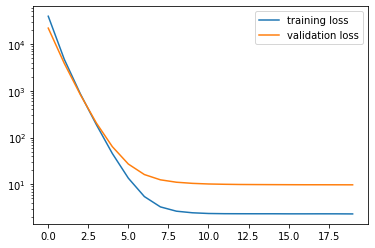




FINAL VALIDATION! ####################################################


Train Set

Validation set: Average loss: 4.0798, Average Abs Error: [0.01579232], Maximum Abs Error: [71.02672] 

Test Set

Validation set: Average loss: 9.7500, Average Abs Error: [0.2954879], Maximum Abs Error: [58.62584] 



9.749984741210938

In [56]:
# We instantiate a model
thumb_model_w0 = createModel( input_size  = 3, n_layers=1, 
                    neurons_per_layer = [1],  use_relu_in_last=False,
                    parameter_initialiser=None) # que triste jajajajaja

# nn package also has different loss functions.
# we use mean square error for the regression task
criterion = lambda est,targ,model : MSE_L1_loss(est,targ, model) 

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
#optimizer = torch.optim.SGD(thumb_model_w0.parameters(), lr=1e-8, momentum=0.9, weight_decay=0) # built-in L2 weight decay
optimizer = torch.optim.Adagrad(thumb_model_w0.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3, initial_accumulator_value=0, eps=1e-10)

# Execute the training and validation
losses = full_training_loop(thumb_model_w0, criterion, optimizer, train_loader, val_loader, epochs=20, print_loss_every_batches=200)

print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
validate(criterion, thumb_model_w0, train_loader)
print("Test Set")
validate(criterion, thumb_model_w0, val_loader)

In [57]:
print(thumb_model_w0)

print(thumb_model_w0.parameters())
# Print model's state_dict
print("\n\nModel's state_dict:")
for param_tensor in thumb_model_w0.state_dict():
    print(param_tensor, "\t", thumb_model_w0.state_dict()[param_tensor])

FCModel(
  (network): Sequential(
    (Linear0): Linear(in_features=3, out_features=1, bias=True)
  )
)
<generator object Module.parameters at 0x7f68cc1e2eb0>


Model's state_dict:
network.Linear0.weight 	 tensor([[ 0.4618,  0.7738, -0.0093]], device='cuda:0')
network.Linear0.bias 	 tensor([0.0390], device='cuda:0')


### (b.1) Obtain $R_0$ from $D$ and estimated $w_0$ with the other rule of thumb

In [56]:
phase_vigilant = json.load(open(vig_path))
targets = torch.tensor(phase_vigilant['GT_R0s']).float()
estimated_w0=thumb_model_w0(data.to(device)).cpu().detach().clone()
data = torch.cat([estimated_w0, torch.Tensor(phase_vigilant['Ds']).unsqueeze(1), 
                     torch.Tensor(phase_vigilant['Ds']).unsqueeze(1)*(estimated_w0)], 1).float() # the potential arguments
                                                                # to the empirical function we are looking for

full_dataset = CustomDataset(data, targets)
train_size = int(0.95 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

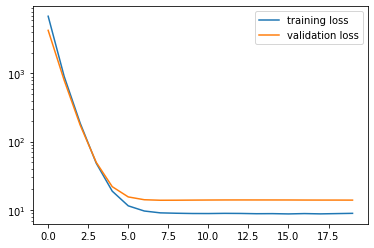




FINAL VALIDATION! ####################################################


Train Set

Validation set: Average loss: 2.4046, Average Abs Error: [0.00964551], Maximum Abs Error: [190.30878] 

Test Set

Validation set: Average loss: 13.9208, Average Abs Error: [0.24311607], Maximum Abs Error: [157.76016] 



13.920816040039062

In [57]:
# We instantiate a model
thumb_model_R0_1 = createModel( input_size  = 3, n_layers=1, 
                    neurons_per_layer = [1],  use_relu_in_last=False,
                    parameter_initialiser=None) # que triste jajajajaja

# nn package also has different loss functions.
# we use mean square error for the regression task
criterion = lambda est,targ,model : MSE_L1_loss(est,targ, model) 

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
#optimizer = torch.optim.SGD(thumb_model_R0_1.parameters(), lr=1e-9, momentum=0.2, weight_decay=0) # built-in L2 weight decay
optimizer = torch.optim.Adagrad(thumb_model_R0_1.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3, initial_accumulator_value=0, eps=1e-10)
#optimizer = torch.optim.Adam(thumb_model_R0_1.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.7, amsgrad=True) 
#optimizer = torch.optim.RMSprop(thumb_model_R0_1.parameters(), lr=0.01, alpha=0.7, eps=1e-08, weight_decay=0.2, momentum=0.1, centered=False)

# Execute the training and validation
losses = full_training_loop(thumb_model_R0_1, criterion, optimizer, train_loader, val_loader, epochs=20, print_loss_every_batches=400)

print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
validate(criterion, thumb_model_R0_1, train_loader)
print("Test Set")
validate(criterion, thumb_model_R0_1, val_loader)

In [58]:
print(thumb_model_R0_1)

print(thumb_model_R0_1.parameters())
# Print model's state_dict
print("\n\nModel's state_dict:")
for param_tensor in thumb_model_R0_1.state_dict():
    print(param_tensor, "\t", thumb_model_R0_1.state_dict()[param_tensor])

FCModel(
  (network): Sequential(
    (Linear0): Linear(in_features=3, out_features=1, bias=True)
  )
)
<generator object Module.parameters at 0x7f3a23158820>


Model's state_dict:
network.Linear0.weight 	 tensor([[0.4899, 0.8057, 0.0068]], device='cuda:0')
network.Linear0.bias 	 tensor([0.0829], device='cuda:0')


### (b.2) Obtain $R_0$ from $D$ and $W$

In [59]:
phase_vigilant = json.load(open(vig_path))
targets = torch.tensor(phase_vigilant['GT_R0s']).float()
data = torch.tensor(np.array([phase_vigilant['Ws'], phase_vigilant['Ds'], 
                     np.array(phase_vigilant['Ds'])*np.array(phase_vigilant['Ws'])])).transpose(0,1).float() # the potential arguments
                                                                # to the empirical function we are looking for

full_dataset = CustomDataset(data, targets)
train_size = int(0.95 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

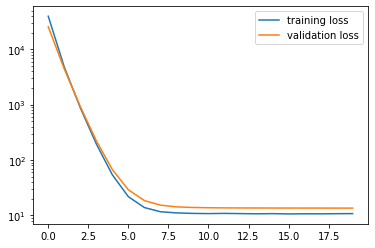




FINAL VALIDATION! ####################################################


Train Set

Validation set: Average loss: 6.2196, Average Abs Error: [0.01839661], Maximum Abs Error: [90.207825] 

Test Set

Validation set: Average loss: 13.5835, Average Abs Error: [0.31722298], Maximum Abs Error: [86.62955] 



13.58348388671875

In [60]:
# We instantiate a model
thumb_model_R0_2 = createModel( input_size  = 3, n_layers=1, 
                    neurons_per_layer = [1],  use_relu_in_last=False,
                    parameter_initialiser=None) # que triste jajajajaja

# nn package also has different loss functions.
# we use mean square error for the regression task
criterion = lambda est,targ,model : MSE_L1_loss(est,targ, model) 

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
#optimizer = torch.optim.SGD(thumb_model_R0_2.parameters(), lr=1e-9, momentum=0.2, weight_decay=0) # built-in L2 weight decay
optimizer = torch.optim.Adagrad(thumb_model_R0_2.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3, initial_accumulator_value=0, eps=1e-10)
#optimizer = torch.optim.RMSprop(thumb_model_R0_2.parameters(), lr=0.01, alpha=0.8, eps=1e-08, weight_decay=0.3, momentum=0.1, centered=False)

# Execute the training and validation
losses = full_training_loop(thumb_model_R0_2, criterion, optimizer, train_loader, val_loader, epochs=20, print_loss_every_batches=100)

print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
validate(criterion, thumb_model_R0_2, train_loader)
print("Test Set")
validate(criterion, thumb_model_R0_2, val_loader)

In [61]:
print(thumb_model_R0_2)

print(thumb_model_R0_2.parameters())
# Print model's state_dict
print("\n\nModel's state_dict:")
for param_tensor in thumb_model_R0_2.state_dict():
    print(param_tensor, "\t", thumb_model_R0_2.state_dict()[param_tensor])

FCModel(
  (network): Sequential(
    (Linear0): Linear(in_features=3, out_features=1, bias=True)
  )
)
<generator object Module.parameters at 0x7f3a24505740>


Model's state_dict:
network.Linear0.weight 	 tensor([[ 4.7518e-01,  7.9408e-01, -4.0550e-04]], device='cuda:0')
network.Linear0.bias 	 tensor([0.0676], device='cuda:0')


### (c) Obtain $w_0, R_0$ from $D$, $slope$ and $Profile$ as a ten layer fc model

In [63]:
phase_vigilant = json.load(open(vig_path))
targets = torch.tensor([phase_vigilant['GT_w0s'], phase_vigilant['GT_R0s']]).transpose(0,1).float()
data = torch.cat([torch.Tensor(phase_vigilant['slope']).unsqueeze(1), torch.Tensor(phase_vigilant['Ds']).unsqueeze(1), 
                 torch.Tensor(phase_vigilant['profiles'])],1).float()

full_dataset = CustomDataset(data, targets)
train_size = int(0.95 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

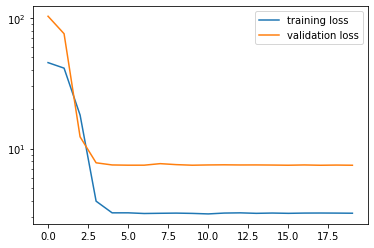




FINAL VALIDATION! ####################################################


Train Set

Validation set: Average loss: 3.2028, Average Abs Error: [0.00708607 0.01857062], Maximum Abs Error: [21.026888 55.686943] 

Test Set

Validation set: Average loss: 7.4756, Average Abs Error: [0.13423684 0.34728697], Maximum Abs Error: [20.973112 54.313057] 



7.4756324768066404

In [66]:
# We instantiate a model
fc_model_w0_R0 = createModel( input_size  = 2+len(phase_vigilant['profiles'][0]), n_layers =10, 
                    neurons_per_layer = [10,10,5,5,4,4,3,3,2,2],  use_relu_in_last=False,
                    parameter_initialiser=None) 

# nn package also has different loss functions.
# we use mean square error for the regression task
criterion = lambda est,targ,model : MSE_L1_loss(est,targ, model) 

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
#optimizer = torch.optim.SGD(fc_model_w0_R0.parameters(), lr=1e-3, momentum=0.9, weight_decay=0) # built-in L2 weight decay
optimizer = torch.optim.Adagrad(fc_model_w0_R0.parameters(), lr=0.1, lr_decay=0.001, weight_decay=0.3, initial_accumulator_value=0, eps=1e-10)
#optimizer = optimizer = torch.optim.RMSprop(fc_model_w0_R0.parameters(), lr=0.02, alpha=0.8, eps=1e-08, weight_decay=0.1, momentum=0.1, centered=False)

# Execute the training and validation
losses = full_training_loop(fc_model_w0_R0, criterion, optimizer, train_loader, val_loader, epochs=20, print_loss_every_batches=300)

print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
validate(criterion, fc_model_w0_R0, train_loader)
print("Test Set")
validate(criterion, fc_model_w0_R0, val_loader)

In [67]:
print(fc_model_w0_R0)
print(fc_model_w0_R0.parameters())
# Print model's state_dict
print("\n\nModel's state_dict:")
for param_tensor in fc_model_w0_R0.state_dict():
    print(param_tensor, "\t", fc_model_w0_R0.state_dict()[param_tensor])

FCModel(
  (network): Sequential(
    (Linear0): Linear(in_features=759, out_features=10, bias=True)
    (ReLU0): ReLU()
    (Linear1): Linear(in_features=10, out_features=10, bias=True)
    (ReLU1): ReLU()
    (Linear2): Linear(in_features=10, out_features=5, bias=True)
    (ReLU2): ReLU()
    (Linear3): Linear(in_features=5, out_features=5, bias=True)
    (ReLU3): ReLU()
    (Linear4): Linear(in_features=5, out_features=4, bias=True)
    (ReLU4): ReLU()
    (Linear5): Linear(in_features=4, out_features=4, bias=True)
    (ReLU5): ReLU()
    (Linear6): Linear(in_features=4, out_features=3, bias=True)
    (ReLU6): ReLU()
    (Linear7): Linear(in_features=3, out_features=3, bias=True)
    (ReLU7): ReLU()
    (Linear8): Linear(in_features=3, out_features=2, bias=True)
    (ReLU8): ReLU()
    (Linear9): Linear(in_features=2, out_features=2, bias=True)
  )
)
<generator object Module.parameters at 0x7f3a23fa7580>


Model's state_dict:
network.Linear0.weight 	 tensor([[ 0.0031,  0.0030, -0.00

### We save the models

In [18]:
np.savez(f"./OUTPUT/EMPIRICAL_LAWS/{experiment_name}/LS_Models.np", LS_w_1_a, LS_w_2_a, LS_w_3_a, LS_w_4_a, LS_w_5_a, LS_w_1_b1, LS_w_2_b1, LS_w_3_b1, LS_w_4_b1, LS_w_5_b1, LS_w_1_b2, LS_w_2_b2, LS_w_3_b2, LS_w_4_b2, LS_w_5_b2, LS_w_6_b2, LS_w_7_b2)

array([3.63397381])

In [68]:
torch.save({
            'thumb_model_w0': thumb_model_w0.state_dict(),
            'thumb_model_R0_1': thumb_model_R0_1.state_dict(),
            'thumb_model_R0_2': thumb_model_R0_2.state_dict(),
            'fc_model_w0_R0': fc_model_w0_R0.state_dict()
            }, f"./OUTPUT/EMPIRICAL_LAWS/{experiment_name}/ML_Models.pt")

## Step 5: Use the computed models to get estimates in experimental images
We first reload the trained models

In [2]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import json


assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
ar_dict=np.load(f"./OUTPUT/EMPIRICAL_LAWS/{experiment_name}/LS_Models.np.npz")
LS_w_1_a=ar_dict['arr_0']
LS_w_2_a=ar_dict['arr_1']
LS_w_3_a=ar_dict['arr_2']
LS_w_4_a=ar_dict['arr_3']
LS_w_5_a=ar_dict['arr_4']
LS_w_1_b1=ar_dict['arr_5']
LS_w_2_b1=ar_dict['arr_6']
LS_w_3_b1=ar_dict['arr_7']
LS_w_4_b1=ar_dict['arr_8']
LS_w_5_b1=ar_dict['arr_9']
LS_w_1_b2=ar_dict['arr_10']
LS_w_2_b2=ar_dict['arr_11']
LS_w_3_b2=ar_dict['arr_12']
LS_w_4_b2=ar_dict['arr_13']
LS_w_5_b2=ar_dict['arr_14']
LS_w_6_b2=ar_dict['arr_15']
LS_w_7_b2=ar_dict['arr_16']

In [5]:
from collections import OrderedDict

class FCModel(nn.Module):
    def __init__(self, input_size, n_layers, neurons_per_layer, use_relu_in_last=False): 
        # last layer number of neurons will be equal to the output size!
        super(FCModel, self).__init__()
        self.input_size = input_size

        sequence=[(f'Linear0', nn.Linear(input_size, neurons_per_layer[0])), (f'ReLU0', nn.ReLU())]
        for i in range(1,n_layers):
            sequence.append((f'Linear{i}', nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i])))
            sequence.append((f'ReLU{i}', nn.ReLU()))
            
        if use_relu_in_last==False:
            sequence=sequence[:-1]
        self.network = nn.Sequential(OrderedDict( sequence ))

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
def createModel(input_size  = 28*28, 
                output_size = 10, n_layers=128, neurons_per_layer = 128*[30], use_relu_in_last=False,
                parameter_initialiser=None):

    torch.manual_seed(0) # seed for reproductibility

    model = FCModel(input_size, n_layers, neurons_per_layer, use_relu_in_last)

    # subroutine to count number of parameters in the model
    def get_n_params(model):
        np=0
        for p in list(model.parameters()):
            np += p.numel()
        return np

    print(f"Number of parameters in model {get_n_params(model)}")

    # move model to gpu if available
    model.to(device)
    if not parameter_initialiser==None:
        initialize_parameters(model)
    return model

In [6]:
thumb_model_w0 = createModel( input_size  = 3, n_layers=1, 
                    neurons_per_layer = [1],  use_relu_in_last=False,
                    parameter_initialiser=None)
thumb_model_R0_1 = createModel( input_size  = 3, n_layers=1, 
                    neurons_per_layer = [1],  use_relu_in_last=False,
                    parameter_initialiser=None)
thumb_model_R0_2 = createModel( input_size  = 3, n_layers=1, 
                    neurons_per_layer = [1],  use_relu_in_last=False,
                    parameter_initialiser=None)
fc_model_w0_R0 = createModel( input_size  = 2+757, n_layers =10, 
                    neurons_per_layer = [10,10,5,5,4,4,3,3,2,2],  use_relu_in_last=False,
                    parameter_initialiser=None)

checkpoint = torch.load(f"./OUTPUT/EMPIRICAL_LAWS/{experiment_name}/ML_Models.pt")
thumb_model_w0.load_state_dict(checkpoint['thumb_model_w0'])
thumb_model_R0_1.load_state_dict(checkpoint['thumb_model_R0_1'])
thumb_model_R0_2.load_state_dict(checkpoint['thumb_model_R0_2'])
fc_model_w0_R0.load_state_dict(checkpoint['fc_model_w0_R0'])

Number of parameters in model 4
Number of parameters in model 4
Number of parameters in model 4
Number of parameters in model 7880


<All keys matched successfully>

In [7]:
from ipyfilechooser import FileChooser
# Create and display a FileChooser widget
fc = FileChooser('/home/oiangu/Desktop/Conical_Refraction_Polarimeter')
display(fc)

FileChooser(path='/home/oiangu/Desktop/Conical_Refraction_Polarimeter', filename='', title='', show_hidden=Fal…

In [157]:
image_full_path=fc.selected
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)
if im is None:
    print(f" Unable to import image {image_full_path}")
    raise ValueError
plt.imshow(im)
plt.show()

Compute Gradient algorithm (also Mirror and Rotation ya que estamos)

In [158]:
import os
os.chdir(f"../../..")
import sys
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm, Gradient_Algorithm
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt

image=im.copy()
saturation=0.9
pol_or_CR="pol" 
deg_or_rad="deg" # for the final output
image_depth=8 # or 16 bit per pixel
image_shortest_side=540
randomization_seed=666
recenter_average_image=False


# 4. GRAVICENTER iX and PROFILES ######################################
X=int(image_shortest_side*1.4/2)
plot_3d_finnes=0.3 # value that should go in (0,1]. 1 means all the pixels will be ploted in the 3d plot, 0.5 only half of them



# 5. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Also a gradient algorithm
theta_min_Rot=-np.pi
theta_max_Rot=np.pi
rad_min_Grav=3
rad_max_Grav=image_shortest_side
theta_min_Mir=0
theta_max_Mir=np.pi
initial_guess_delta_rad=0.1
initial_guess_delta_pix=10
use_exact_gravicenter=True
precision_quadratic=1e-10
max_it_quadratic=100
cost_tolerance_quadratic=1e-14
precision_fibonacci=1e-10
max_points_fibonacci=100
cost_tolerance_fibonacci=1e-14


##################################################################
##################################################################
im_type=np.uint16 if image_depth==16 else np.uint8
max_intensity=65535 if image_depth==16 else 255
np.random.seed(randomization_seed)
polCR=1 if pol_or_CR=='CR' else 0.5

# 4. GRAVICENTER iX ###############################
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def compute_raw_to_centered_iX(image, X, interpolation_flag=None):

    g_raw = compute_intensity_gravity_center(image)
    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_image = np.zeros( (2*X+1, 2*X+1),  dtype = image.dtype )

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = np.rint(g_raw).astype(int) #[N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ 2 (h,w)]
    unclipped_lower = g_index_raw[:]-X
    unclipped_upper = g_index_raw[:]+X+1
    # unclippde could get out of bounds for the indices, so we clip them
    lower_bound = np.clip( unclipped_lower, a_min=0, a_max=image.shape)
    upper_bound = np.clip( unclipped_upper, a_min=0, a_max=image.shape)
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    centered_image[padding_lower[0]:padding_upper[0] or None,
                                    padding_lower[1]:padding_upper[1] or None ] = \
                  image[lower_bound[0]:upper_bound[0],
                                      lower_bound[1]:upper_bound[1]]
    if interpolation_flag==None:
        return centered_image
    else:
        # We compute the center of gravity of the cropped images, if everything was made allright
        # they should get just centered in the central pixels number X+1 (index X)
        g_centered = compute_intensity_gravity_center(centered_image)

        # We now compute a floating translation of the image so that the gravicenter is exactly
        # centered at pixel (607.5, 607.5) (exact center of the image in pixel coordinates staring
        # form (0,0) and having size (607*2+1)x2), instead of being centered at the beginning of
        # around pixel (607,607) as is now
        translate_vectors = X+0.5-g_centered #[ 2(h,w)]
        T = np.float64([[1,0, translate_vectors[1]], [0,1, translate_vectors[0]]])
        return cv2.warpAffine( centered_image, T, (X*2+1, X*2+1),
                    flags=interpolation_flag) # interpolation method

image = max_intensity*(image.astype(np.float64)/image.max())
image = np.where( image<=(max_intensity*saturation), image, max_intensity*saturation)
image = compute_raw_to_centered_iX(image, X)
# saturated and iX

# 6. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Results will be gathered in a table and outputed as an excel csv
# Mock Image Loader
# Computar el angulo de cada uno en un dataframe donde una de las entradas sea results y haya un result per fibo qfs y per rotation y mirror affine. Y luego procesar en un 7º paso estos angulos para obtener los angulos relativos etc y perhaps hacer tablucha con ground truth menos el resulting delta angle medido por el algoritmo
image_loader = Image_Manager(mode=X, interpolation_flag=None)
# Define the ROTATION ALGORITHM
rotation_algorithm = Rotation_Algorithm(image_loader,
    theta_min_Rot, theta_max_Rot, None,
    initial_guess_delta_rad, use_exact_gravicenter, initialize_it=False)

# Define the Affine Mirror algorithm
mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
    theta_min_Mir, theta_max_Mir, None,
    initial_guess_delta_rad, method="aff", left_vs_right=True, use_exact_gravicenter=use_exact_gravicenter, initialize_it=False)

# Define the Gradient algorithm
gradient_algorithm = Gradient_Algorithm(image_loader,
        rad_min_Grav, rad_max_Grav,
        initial_guess_delta_pix,
        use_exact_gravicenter)

# A dictionary to gather all the resulting angles for each image

individual_image_results = { 'polarization_method':[], 'optimization_1d':[], 'found_phiCR':[], 'predicted_opt_precision':[] }

def to_result_dict(result_dict, alg, alg_name, opt_name, im_names):
    for key, name in zip(alg.times.keys(), im_names):
        result_dict['polarization_method'].append(alg_name)
        result_dict['optimization_1d'].append(opt_name)
        result_dict['found_phiCR'].append(alg.angles[key])
        result_dict['predicted_opt_precision'].append(alg.precisions[key])
image_container=np.zeros( (1, 2*X+1, 2*X+1), dtype=np.float64)
image_names=[]
# charge the image
image_container[0]=image.astype(np.float64)
image_names.append(f"{fc.selected_filename}")

# charge the image loader:
image_loader.import_converted_images_as_array(image_container, image_names)
# Execute the Rotation and Mirror Algorithms:
# ROTATION ######
interpolation_flag=None
# the interpolation algorithm used in case we disbale its usage for the iX image obtention will be the Lanczos one
rotation_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Quadratic", image_names)
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Fibonacci", image_names)

# MIRROR #######
mirror_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Quadratic", image_names)
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Fibonacci", image_names)

# GRADIENT #######
optimal_masked_gravs={}
optimal_radii={}
grav=compute_intensity_gravity_center(image)

gradient_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Quadratic", image_names)
optimal_masked_gravs['quad'] = gradient_algorithm.masked_gravs[f"Quadratic_Search_{fc.selected_filename}"]
optimal_radii['quad'] = gradient_algorithm.optimals[f"Quadratic_Search_{fc.selected_filename}"]

gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Fibonacci", image_names)

optimal_masked_gravs['fibo'] = gradient_algorithm.masked_gravs[f"Fibonacci_Search_{fc.selected_filename}"]
optimal_radii['fibo'] = gradient_algorithm.optimals[f"Fibonacci_Search_{fc.selected_filename}"]

masked_grav=(optimal_masked_gravs['quad']+optimal_masked_gravs['fibo'])/2.0
optimal_radi = (optimal_radii['quad']+optimal_radii['fibo'])/2
print(f"\n\nOptimal masked gravs: {optimal_masked_gravs}\nOptimal radii: {optimal_radii}\n\n\n")
print(pd.DataFrame.from_dict(individual_image_results))

# 7. PROCESS FINAL RESULTS ##########################################
def angle_to_pi_pi( angle): # convert any angle to range ()-pi,pi]
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle    

average_found_phiCR=np.mean([angle_to_pi_pi(phi) for i,phi in enumerate(individual_image_results['found_phiCR']) if individual_image_results['polarization_method'][i]!='Gradient'])
print("Average found phiCR:", average_found_phiCR)
print(f"\n\nPredicted slope for main axis: by Gradient {(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])} and by the others averaged {np.tan(-average_found_phiCR)}")



Optimal masked gravs: {'quad': array([303.00396701, 381.52937054]), 'fibo': array([303.00396701, 381.52937054])}
Optimal radii: {'quad': 100.5536, 'fibo': 100.54863177221}



  polarization_method optimization_1d  found_phiCR  predicted_opt_precision
0            Rotation       Quadratic     1.570260             2.900000e-07
1            Rotation       Fibonacci     1.570102             4.100000e-11
2              Mirror       Quadratic     1.570102             4.100000e-11
3              Mirror       Fibonacci     1.570102             4.100000e-11
4            Gradient       Quadratic     1.521560             9.800000e-03
5            Gradient       Fibonacci     1.521560             1.400000e-10
Average found phiCR: 1.5701414158836984


Predicted slope for main axis: by Gradient -20.293826784807163 and by the others averaged -1526.9250212993643


/home/oiangu/Desktop/Conical_Refraction_Polarimeter/SOURCE/Polarization_Obtention_Algorithms.py:602: RuntimeWarning: invalid value encountered in double_scalars
  new_grav = np.nan_to_num([np.dot(intensity_in_h, np.arange(circle.shape[0]))/total_intensity,
/home/oiangu/Desktop/Conical_Refraction_Polarimeter/SOURCE/Polarization_Obtention_Algorithms.py:603: RuntimeWarning: invalid value encountered in double_scalars
  np.dot(intensity_in_w, np.arange(circle.shape[1]))/total_intensity], nan=self.mode) # The nan to this number works only because the gravicenter is never exctly centered there, else the cost function would yield 0 and the three intial points would be aligned


Find automatic W and Plot the Profiles

Slope with gradient: -0.049276068560348774; Slope with angles -0.0006549110048305005


<IPython.core.display.Javascript object>


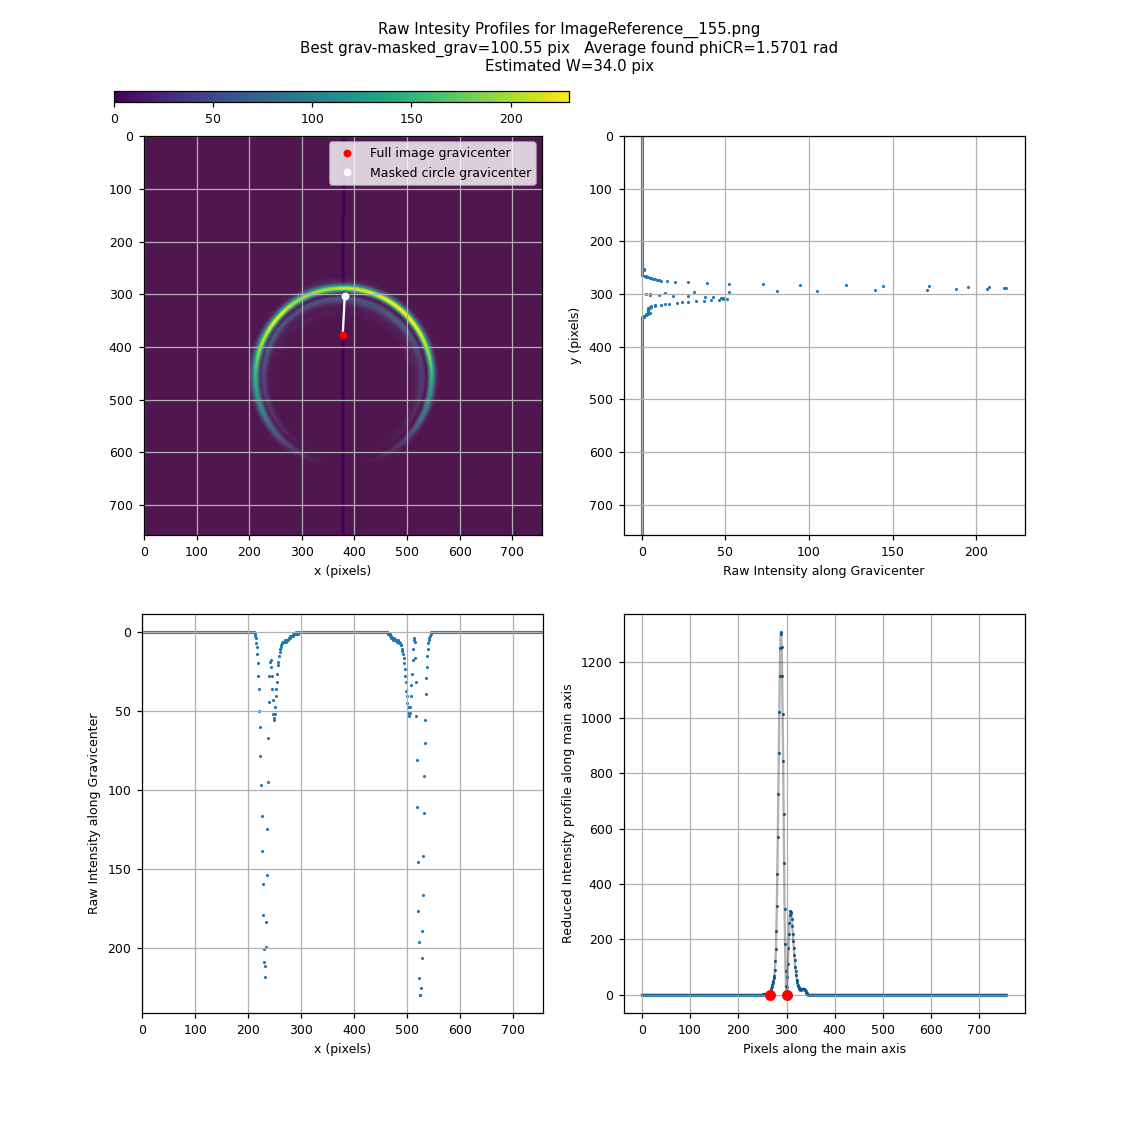

In [159]:
### FIND the W ########################################################
dist = 0.5 # to choose whether to project in one or the other axis
pix_spacing=3
tolerance_first=7
tolerance_then=0.1
cols = np.broadcast_to( np.arange(X*2+1), (X*2+1,X*2+1)) #[h,w]
rows = cols.swapaxes(0,1) #[h,w]
if abs(average_found_phiCR-np.pi/2)>dist and abs(average_found_phiCR+np.pi/2)>dist:
    slope=(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])
    # using as slope the average found phiCR is better
    #slope=np.tan(-average_found_phiCR)
    print(f"Slope with gradient: {(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])}; Slope with angles {np.tan(-average_found_phiCR)}")
    mask=(rows<( slope*(cols-grav[1]) +grav[0]+pix_spacing )) & (rows>( slope*(cols-grav[1]) +grav[0]-pix_spacing ))

    filtered_image=np.where(mask, image, 0)
    filtered_line=np.where(mask, image, 200)
    prof_filt=np.sum(filtered_image,axis=0)

    grav_x=round(grav[1])
else:
    slope=(masked_grav[1]-grav[1])/(masked_grav[0]-grav[0])
    # using as slope the average found phiCR is better
    slope=1/np.tan(-average_found_phiCR)
    print(f"Slope with gradient: {(masked_grav[1]-grav[1])/(masked_grav[0]-grav[0])}; Slope with angles {1/np.tan(-average_found_phiCR)}")
    mask=(cols<( slope*(rows-grav[0]) +grav[1]+pix_spacing )) & (cols>( slope*(rows-grav[0]) +grav[1]-pix_spacing ))

    filtered_image=np.where(mask, image, 0)
    filtered_line=np.where(mask, image, 200)
    prof_filt=np.sum(filtered_image,axis=1)
    grav_x=round(grav[0])
    
if np.sum(prof_filt[:grav_x])<np.sum(prof_filt[grav_x:]): # then the bump is on the right
    prof_filt=np.flip(prof_filt)
# At this point any profile has the bump in the left
first_increment_index=np.argmax(prof_filt>=tolerance_first) # it will stop in the first True it finds
diff_prof=prof_filt[1:]-prof_filt[:-1]
is_increasing=(diff_prof>=tolerance_then) # we select the points whose next point is higher than them
#first_increment_index=np.argmax(is_increasing)
peak_of_high_bump_index=first_increment_index+np.argmin(is_increasing[first_increment_index:])
valley_min_index=peak_of_high_bump_index+np.argmax(is_increasing[peak_of_high_bump_index:])

W = (valley_min_index-first_increment_index)*np.sqrt(1+slope**2) 

# PLOT THE PROFILES #################################################
pix_spacing=10
%matplotlib notebook

plt.rc('font', size=8) 

prof_x=image[int(grav[0])]
prof_y=image[:,int(grav[1])]
fig = plt.figure(figsize=(2*4.5, 2*4.5))
axes=fig.subplots(2,2)
cm=axes[0, 0].imshow(image, cmap='viridis')
axes[0,0].plot([grav[1],masked_grav[1]], [grav[0], masked_grav[0]], '-w', markersize=1)
axes[0,0].plot(grav[1], grav[0], 'or', markersize=4, label="Full image gravicenter")
axes[0,0].plot(masked_grav[1], masked_grav[0], 'ow', markersize=4, label="Masked circle gravicenter")
axes[0,0].legend()
axes[0,0].grid(True)
axes[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
axes[0,1].set_ylim((0,len(prof_y)))
axes[0,1].invert_yaxis()
axes[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in x')
axes[1,0].set_xlim((0,len(prof_x)))
axes[1,0].invert_yaxis()
axes[0,0].set_xlabel("x (pixels)")
#axes[0,0].set_ylabel("y (pixels)")
axes[0,1].set_xlabel("Raw Intensity along Gravicenter")
axes[0,1].set_ylabel("y (pixels)")
axes[1,0].set_ylabel("Raw Intensity along Gravicenter")
axes[1,0].set_xlabel("x (pixels)")
axes[1,0].grid(True)
axes[0,1].grid(True)

axes[0,0].imshow(filtered_line, alpha=0.1, label="Optimal Radious Mask")
axes[1,1].plot(np.arange(len(prof_filt))*np.sqrt(1+slope**2), prof_filt , 'k', markersize=1, alpha=0.3, label=f'Intensity profile along main axis')
axes[1,1].scatter(np.arange(len(prof_filt))*np.sqrt(1+slope**2), prof_filt , s=1, label=f'Intensity profile along main axis')
axes[1,1].plot([first_increment_index*np.sqrt(1+slope**2) , valley_min_index*np.sqrt(1+slope**2) ], [0,0], 'or')
axes[1,1].grid()
axes[1,1].set_ylabel(f'Reduced Intensity profile along main axis')
axes[1,1].set_xlabel("Pixels along the main axis") 
fig.suptitle(f"Raw Intesity Profiles for Image{fc.selected_filename}\nBest grav-masked_grav={optimal_radi:3.5} pix   Average found phiCR={average_found_phiCR:3.5} rad\nEstimated W={W:3.5} pix")
cbax=fig.add_axes([0.1,0.91,0.4,0.01])
fig.colorbar(cm, ax=axes[0,0], cax=cbax, orientation='horizontal')

plt.show()

Run the ML models and the LS solutions on the image!

In [160]:
print("Estimate w_0 using Least Square Models: #####################\n")
print(f"Using w_0(W) = {np.array([W])@LS_w_1_a}")
print(f"Using w_0(1, W) = {np.array([1, W])@LS_w_2_a}")
print(f"Using w_0(1, W, D) = {np.array([1, W, optimal_radi])@LS_w_3_a}")
print(f"Using w_0(1, W, D, WD) = {np.array([1, W, optimal_radi, W*optimal_radi])@LS_w_4_a}")
print(f"Using w_0( W, D) = {np.array([ W, optimal_radi])@LS_w_5_a}")

print("\n\nEstimate R_0 using Least Square Models: #####################\nModels (b.1)")
hat_w0=np.array([W])@LS_w_1_a
print(f"Using R_0(hat_w0) = {np.array([hat_w0])@LS_w_1_b1}")
print(f"Using R_0(1, hat_w0) = {np.array([1, hat_w0])@LS_w_2_b1}")
print(f"Using R_0(1, hat_w0, D) = {np.array([1, hat_w0, optimal_radi])@LS_w_3_b1}")
print(f"Using R_0(1, hat_w0, D, hat_w0D) = {np.array([1, hat_w0, optimal_radi, hat_w0*optimal_radi])@LS_w_4_b1}")
print(f"Using R_0( hat_w0, D) = {np.array([ hat_w0, optimal_radi])@LS_w_5_b1}")

print("\nModels (b.2)")
print(f"Using R_0(W) = {np.array([W])@LS_w_1_b2}")
print(f"Using R_0(1, W) = {np.array([1, W])@LS_w_2_b2}")
print(f"Using R_0(1, W, D) = {np.array([1, W, optimal_radi])@LS_w_3_b2}")
print(f"Using R_0(1, W, D, WD) = {np.array([1, W, optimal_radi, W*optimal_radi])@LS_w_4_b2}")
print(f"Using R_0( W, D) = {np.array([ W, optimal_radi])@LS_w_5_b2}")
print(f"Using R_0( 1, D) = {np.array([ 1, optimal_radi])@LS_w_6_b2}")
print(f"Using R_0( D) = {np.array([ optimal_radi])@LS_w_7_b2}")

Estimate w_0 using Least Square Models: #####################

Using w_0(W) = 12.162377726736667
Using w_0(1, W) = 12.254283267811187
Using w_0(1, W, D) = 12.445641922590312
Using w_0(1, W, D, WD) = 12.245233873478908
Using w_0( W, D) = 12.4639662701149


Estimate R_0 using Least Square Models: #####################
Models (b.1)
Using R_0(hat_w0) = 44.19776215888396
Using R_0(1, hat_w0) = 125.6287143538751
Using R_0(1, hat_w0, D) = 154.82227006639573
Using R_0(1, hat_w0, D, hat_w0D) = 153.0228831488731
Using R_0( hat_w0, D) = 153.9972290145207

Models (b.2)
Using R_0(W) = 44.19776215888396
Using R_0(1, W) = 125.6287143538748
Using R_0(1, W, D) = 154.82227006639516
Using R_0(1, W, D, WD) = 153.02288314887332
Using R_0( W, D) = 153.9972290145208
Using R_0( 1, D) = 131.67663699061134
Using R_0( D) = 131.75697672932586


In [143]:
print("Estimate w_0 and R_0 using ML models: #########################\n")
estimated_w0=thumb_model_w0(torch.Tensor([W, optimal_radi, W*optimal_radi]).to(device)).item()
print(f"Estimated w0 by a: {estimated_w0}")
print(f"Estimated R0 by b.1: {thumb_model_R0_1(torch.Tensor([estimated_w0, optimal_radi, estimated_w0*optimal_radi]).to(device)).item()}")
print(f"Estimated R0 by b.2: {thumb_model_R0_2(torch.Tensor([W, optimal_radi, W*optimal_radi]).to(device)).item()}")
print(f"Estimated R0,w0 by b.2: {fc_model_w0_R0(torch.Tensor([slope]+[optimal_radi]+prof_filt.tolist()).to(device)).cpu().tolist()}")

Estimate w_0 and R_0 using ML models: #########################

Estimated w0 by a: 61.449546813964844
Estimated R0 by b.1: 152.96949768066406
Estimated R0 by b.2: 94.5019760131836
Estimated R0,w0 by b.2: [[28.973114013671875, 124.31305694580078]]
